In [1]:
import argparse
import os
import sys
import joblib
from joblib import Parallel, delayed
output_stream = sys.stdout
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
import warnings
warnings.filterwarnings("ignore")

In [2]:
test_p = 0.5
N = 2000
n = 10
m = 4
np.random.seed(27)
y_nom = np.random.uniform(2,4,n)
y_data = y_nom
num_context = 20
num_reps = int(N/num_context)
for scene in range(num_context-1):
    np.random.seed(scene)
    y_data = np.vstack([y_data,np.maximum(y_nom + np.random.normal(0,0.05,n),0)])
np.random.seed(27)
C = 200
c = np.random.uniform(30,50,n)
Q = np.random.uniform(-0.2,0.2,(n,m))
d = np.random.uniform(10,20,n)
t = np.random.uniform(0.1,0.3,n)
h = np.random.uniform(0.1,0.3,n)

In [3]:
def gen_sigmu_varied(n,m,N = 500,seed = 0):
    np.random.seed(seed)
    sig = []
    context = []
    for i in range(N):
        F = np.random.normal(size = (n,m))
        context.append(F)
        csig = 0.2*F@(F.T)
        sig.append(csig)
    return np.stack(sig), np.stack(context)

def gen_demand_varied(sig,mu,d,N,seed=399):
    pointlist = []
    np.random.seed(seed)
    for i in range(N):
        d_train = np.random.multivariate_normal(d - 0.1*mu[i],sig[i])
        pointlist.append(d_train)
    return np.vstack(pointlist)

In [4]:
sig, context = gen_sigmu_varied(n,m,num_context,seed= 0)
sig = np.vstack([sig]*num_reps)
context_dat = np.vstack([context]*num_reps)
y_data = np.vstack([y_data]*num_reps)

In [5]:
test_valid_indices = np.random.choice(N,int((test_p+0.2)*N), replace=False)
test_indices = test_valid_indices[:int((test_p)*N)]
valid_indices = test_valid_indices[int((test_p)*N):]
train_indices = [i for i in range(N) if i not in test_valid_indices]
context_inds = {}
test_inds = {}
for j in range(num_context):
  context_inds[j]= [i for i in train_indices if j*num_reps <= i <= (j+1)*num_reps]
  test_inds[j] = [i for i in test_valid_indices if j*num_reps <= i <= (j+1)*num_reps]

In [6]:
seed = 0
data = gen_demand_varied(sig,y_data,d,N,seed= 0)
train = data[train_indices]
init_bval = np.mean(train, axis=0)
init = np.real(sc.linalg.sqrtm(np.cov(train.T)))


In [10]:
sig[0]

array([[ 1.85030737,  0.69882351,  0.6764146 ,  0.51467077,  0.18920241,
        -1.0118227 ,  0.60946353,  0.8581904 , -0.4697768 ,  0.3189837 ],
       [ 0.69882351,  1.07368438, -0.13545933,  0.33471542,  0.6834983 ,
        -0.89460014,  1.14640481,  0.30331168, -0.01528293,  0.16006819],
       [ 0.6764146 , -0.13545933,  0.46298105,  0.1041191 , -0.28708964,
        -0.08458059, -0.21941343,  0.20347514, -0.10888324, -0.02574333],
       [ 0.51467077,  0.33471542,  0.1041191 ,  0.18046727,  0.19321146,
        -0.3454685 ,  0.3016522 ,  0.30804913, -0.20378153,  0.16196128],
       [ 0.18920241,  0.6834983 , -0.28708964,  0.19321146,  0.62037062,
        -0.60879138,  0.77275329,  0.34283286, -0.23250048,  0.34568187],
       [-1.0118227 , -0.89460014, -0.08458059, -0.3454685 , -0.60879138,
         1.64860663, -1.31335685, -0.61989727,  0.1110076 , -0.49309651],
       [ 0.60946353,  1.14640481, -0.21941343,  0.3016522 ,  0.77275329,
        -1.31335685,  1.46081944,  0.2556704 

In [11]:
u = lropt.UncertainParameter(n,
                                uncertainty_set = lropt.Ellipsoidal(p=2, data =data))
# formulate cvxpy variable
L = cp.Variable()
s = cp.Variable(n)
y = cp.Variable(n)
Y = cp.Variable((n,n))
r = lropt.ContextParameter(n, data = y_data)
context = lropt.ContextParameter((n,m), data=context_dat)     
Y_r = cp.Variable(n)
# formulate objective
objective = cp.Minimize(L)

# formulate constraints
constraints = []
constraints += [context >= -200]
cons = [-r@y - Y_r@u + (t+h)@s - L]
for idx in range(n):
    cons += [y[idx]+Y[idx]@u-s[idx]]
    cons += [y[idx]+Y[idx]@u-u[idx]]
constraints += [lropt.max_of_uncertain(cons)<=0]
constraints += [r@Y == Y_r]
constraints += [np.ones(n)@s == C]
constraints += [s <=c, s >=0]
eval_exp = -r@y - r@Y@u + (t+h)@s
# formulate Robust Problem
prob = lropt.RobustProblem(objective, constraints,eval_exp = eval_exp )
# solve
# seed 1, 
trainer = lropt.Trainer(prob)
settings = lropt.TrainerSettings()
settings.set(lr = 0.001,num_iter=1, optimizer = "SGD", seed = 5, init_A = init, init_b = init_bval, init_lam = 2.0, init_mu =2.0, mu_multiplier=1.02, init_alpha = -0.0, test_percentage = test_p, save_history = False, lr_step_size = 50, lr_gamma = 0.5, position = False, random_init = False, num_random_init=6, parallel = False, eta = 0.3, kappa=0.,contextual = True,validate_frequency = 20,test_frequency = 300,predictor = lropt.LinearPredictor(predict_mean = True,pretrain=True, lr=0.001,epochs = 100),obj_scale = 3,max_iter_line_search=30)
result = trainer.train(settings = settings)
A_fin = result.A
b_fin = result.b

Training:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
epslst = np.linspace(0.5, 3, 15)
# Grid search epsilon
result4 = trainer.grid(rholst = epslst, init_A = init, init_b = init_bval, seed = seed, init_alpha = 0., test_percentage =test_p, predictor = result._predictor)
dfgrid = result4.df

In [18]:
result3 = trainer.grid(rholst=epslst, init_A=init,
                    init_b=init_bval, seed=5,
                    init_alpha=0., test_percentage=test_p)
dfgrid2 = result3.df

settings.num_iter = 1
settings.initialize_predictor = True
settings.predictor = lropt.LinearPredictor(predict_mean = True,pretrain=True, lr=0.001,epochs = 100)
result2 = trainer.train(settings=settings)
result6 = trainer.grid(rholst=epslst, init_A=result2.A, init_b=result2.b, init_rho = result2.rho, seed=5, init_alpha=0., test_percentage=test_p,contextual = True, predictor = result2._predictor )
dfgrid3 = result6.df

# dfgrid.to_csv(foldername + f"gridmv_{N,n,r}.csv")
# dfgrid2.to_csv(foldername +f"gridre_{N,n,r}.csv")
# dfgrid3.to_csv(foldername +f"gridpre_{N,n,r}.csv")
# result.df_test.to_csv(foldername +f"trainval_{N,n,r}.csv")
# result.df.to_csv(foldername +f"train_{N,n,r}.csv")

Training:   0%|          | 0/1 [00:25<?, ?it/s]


In [19]:
def calc_eval(u,r,y,Y,t,h,d,s,L):
    val = 0
    vio = 0
    for i in range(u.shape[0]):
        val_cur = -r@y - r@Y@u[i] + (t+h)@s
        val+= val_cur
        sum = (val_cur >= L)
        for j in range(n):
            sum += np.sum((y+Y@u[i] - s) >= 0)
            sum+= np.sum((y + Y@u[i] -u[i]) >= 0)
        vio += (sum >= 0.0001)
    return val/u.shape[0], vio/u.shape[0]


context_evals = 0
context_probs = 0
for j in range(num_context):
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Scenario(
                                                        data=data[context_inds[j]]))
    # Formulate the Robust Problem
    L = cp.Variable()
    s = cp.Variable(n)
    y = cp.Variable(n)
    Y = cp.Variable((n,n))
    r = y_data[j]        
    Y_r = cp.Variable(n)
    # formulate objective
    objective = cp.Minimize(L)

    # formulate constraints
    constraints = []
    cons = [-r@y - Y_r@u + (t+h)@s - L]
    for idx in range(n):
        cons += [y[idx]+Y[idx]@u-s[idx]]
        cons += [y[idx]+Y[idx]@u-u[idx]]
    constraints += [lropt.max_of_uncertain(cons)<=0]
    # constraints = []
    # constraints += [lropt.max_of_uncertain([-r@y - Y_r@u + (t+h)@s - L,y+Y@u-s, y+Y@u - d - Q@u])<= 0]
    # constraints = [lropt.max_of_uncertain([-r@y - Y_r@u + (t+h)@s - L, y[0]+Y[0]@u -s[0],y[1]+Y[1]@u -s[1],y[2]+Y[2]@u -s[2],y[3]+Y[3]@u -s[3],y[4]+Y[4]@u -s[4],y[5]+Y[5]@u -s[5],y[6]+Y[6]@u -s[6],y[7]+Y[7]@u -s[7], y[8]+Y[8]@u -s[8],y[9]+Y[9]@u -s[9],y[0] - d[0] - (Q[0] - Y[0])@u,y[1] - d[1] - (Q[1] - Y[1])@u,y[2] - d[2] - (Q[2] - Y[2])@u ,y[3] - d[3] - (Q[3] - Y[3])@u,y[4] - d[4] - (Q[4] - Y[4])@u,y[5] - d[5] - (Q[5] - Y[5])@u,y[6] - d[6] - (Q[6] - Y[6])@u,y[7] - d[7] - (Q[7] - Y[7])@u,y[8] - d[8] - (Q[8] - Y[8])@u,y[9] - d[9] - (Q[9] - Y[9])@u]) <= 0]
    constraints += [r@Y == Y_r]
    constraints += [np.ones(n)@s == C]
    constraints += [s <=c, s >=0]
    # formulate Robust Problem
    prob_context = lropt.RobustProblem(objective, constraints)
    prob_context.solve()
    eval, prob_vio = calc_eval(data[test_inds[j]],r,y.value,Y.value,t,h,d,s.value,L.value)
    context_evals += eval
    context_probs += prob_vio
context_evals = context_evals/num_context
context_probs = context_probs/num_context

nonrob_evals = 0
nonrob_probs = 0
for j in range(num_context):
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Scenario(
                                                        data=np.mean(data[context_inds[j]],axis=0).reshape(1,n)))
    # Formulate the Robust Problem
    L = cp.Variable()
    s = cp.Variable(n)
    y = cp.Variable(n)
    Y = cp.Variable((n,n))
    r = y_data[j]        
    Y_r = cp.Variable(n)
    # formulate objective
    objective = cp.Minimize(L)

    # formulate constraints
    constraints = []
    cons = [-r@y - Y_r@u + (t+h)@s - L]
    for idx in range(n):
        cons += [y[idx]+Y[idx]@u-s[idx]]
        cons += [y[idx]+Y[idx]@u-u[idx]]
    constraints += [lropt.max_of_uncertain(cons)<=0]
    constraints += [r@Y == Y_r]
    constraints += [np.ones(n)@s == C]
    constraints += [s <=c, s >=0]
    # formulate Robust Problem
    prob_context = lropt.RobustProblem(objective, constraints)
    prob_context.solve()
    eval, prob_vio = calc_eval(data[test_inds[j]],r,y.value,Y.value,t,h,d,s.value,L.value)
    nonrob_evals += eval
    nonrob_probs += prob_vio
nonrob_evals = nonrob_evals / (num_context)
nonrob_probs = nonrob_probs / (num_context)

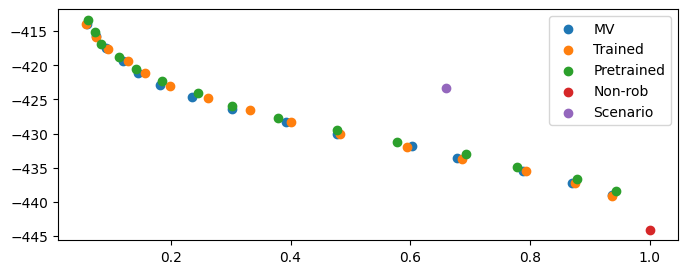

In [20]:
plt.figure(figsize = (8,3))
plt.scatter(dfgrid2["Avg_prob_test"],dfgrid2["Test_val"],label = "MV")
plt.scatter(dfgrid["Avg_prob_test"],dfgrid["Test_val"],label = "Trained")
plt.scatter(dfgrid3["Avg_prob_test"],dfgrid3["Test_val"],label = "Pretrained")
# plt.scatter(df_test["Avg_prob_test"],df_test["Test_val"])
plt.scatter(nonrob_probs,nonrob_evals,label = "Non-rob")
plt.scatter(context_probs,context_evals,label = "Scenario")
plt.legend()
plt.show()

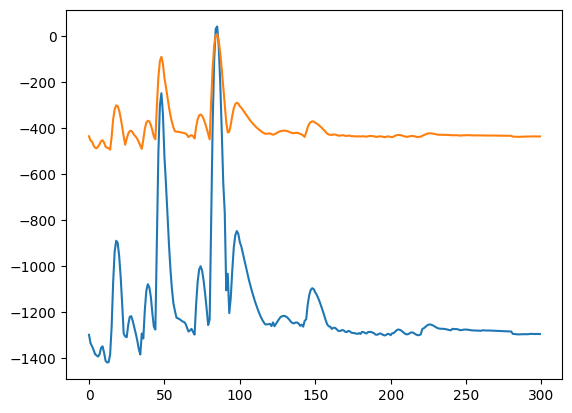

In [21]:
plt.plot(result.df["Lagrangian_val"])
plt.plot(result.df["Train_val"])

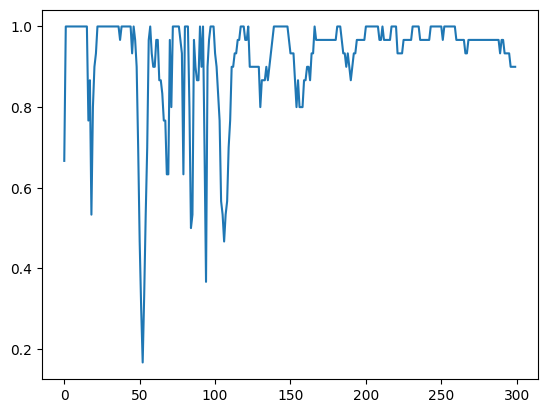

In [22]:
plt.plot(result.df["Avg_prob_train"])
